# OFDM System Performance Testing

NEEDS UPDATING!!!

This notebook employs the same software libraries as those utilized in the Orthogonal Frequency-Division Multiplexing (OFDM) exemplar notebook, executing a cyclical process that incorporates stochastic variation of the transmission (TX) gain to amass data across a spectrum of radio environments. For the documentation and further elucidation of the underlying procedures, the reader is directed to consult the files 10-ofdm-example-func.ipynb, OFDM_SDR_Functions.py, and SDR_Pluto.py.

A singular data stream is generated and subjected to the ofdm modulation. This modulated signal is then repeatedly retransmitted and received within a controlled loop. Concurrently, the radio channel characteristics and the transmit power are systematically varied. This methodology facilitates the aggregation of a dataset, which is instrumental in characterizing the statistical behavior of the system under a variety of environmental conditions and transmission power levels.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from OFDM_SDR_Functions_torch import *
import SDR_Pluto
import random
from config import *
import torch

# SDR Configuration
use_sdr = False # True for SDR or False for channel simulation

# for SDR
SDR_TX_Frequency = int(436e6) # SDR TX frequency
tx_gain_min = -50 # sdr tx max gain
tx_gain_max = 0 # sdr tx min gain
rx_gain = 20 # sdr rx gain

# in case SDR not available, for channel simulation
ch_SINR_min = 5 # channel emulation min SINR
ch_SINR_max = 35 # channel emulation max SINR

# OFDM Configuration is stored in py

## OFDM System Parameters

### SDR Configuration (Optional)

- `use_sdr` (`bool`): Set to `True` to use SDR for transmission and reception, or `False` to run the system in simulation mode.
- `SDR_TX_Frequency` (`int`): SDR Transmission Frequency
- `tx_gain` (`int`): Transmission gain for the SDR
- `rx_gain` (`int`): Reception gain for the SDR
- `tx_frequency` (`float`): Transmission frequency

### 3GPP CDL-C Channel Simulation

In case `use_sdr` is set to False:
- `ch_SINR` (`int`): Signal-to-Interference-plus-Noise Ratio (SINR) for the CDL-C channel emulation

### OFDM System Configuration

- `Qm` (`int`): Modulation order
- `F` (`int`): Number of subcarriers
- `S` (`int`): Number of symbols,=
- `FFT_size` (`int`): FFT size
- `Fp` (`int`): Pilot subcarrier spacing
- `Sp` (`int`): Pilot symbol spacing
- `CP` (`int`): Cyclic Prefix length
- `SCS` (`int`): Subcarrier spacing
- `P` (`int`): Number of pilot subcarriers
- `sn` (`int`): Serial number starting value
- `Qm_sn` (`int`): Serial number modulation order
- `FFT_offset` (`int`): FFT offset, calculated as (FFT size - Number of subcarriers)/2.
- `SampleRate` (`float`): Sample rate, calculated as FFT size * Subcarrier spacing.
- `Ts` (`float`): Sample duration, calculated as 1/(Subcarrier spacing * FFT size).
- `TTI_duration` (`float`): TTI duration in ms, calculated using the provided formula.
- `Pilot_Power` (`float`): Power allocated for the pilot signals
- `PDSCH_power` (`float`): Power allocated for the PDSCH

### SINR Measurement

- `leading_zeros` (`int`): Number of symbols with zero value used for SINR measurement


## Create the modulation tables and the TTI Mask, if you have an SDR, start it

In [2]:
mapping_table_QPSK, de_mapping_table_QPSK = mapping_table(2) # mapping table QPSK (e.g. for pilot symbols)
mapping_table_Qm, de_mapping_table_Qm = mapping_table(Qm, plot=False) # mapping table for Qm

TTI_mask_RE = TTI_mask(S=S,F=F, Fp=Fp, Sp=Sp, FFT_offset=FFT_offset, plotTTI=False)
pilot_symbols = pilot_set(TTI_mask_RE, Pilot_Power)

# start the SDR
if use_sdr: 
    SDR_1 = SDR_Pluto.SDR(SDR_TX_IP="ip:192.168.1.10", SDR_TX_FREQ=SDR_TX_Frequency, SDR_TX_GAIN=-80, SDR_RX_GAIN = 0, SDR_TX_SAMPLERATE=SampleRate, SDR_TX_BANDWIDTH=F*SCS*2)
    SDR_1.SDR_TX_start()

## Data stream creation OFDM Modulation, FFT, and Cyclic Prefix Addition

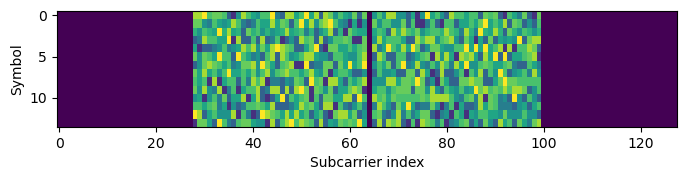

In [3]:
def create_OFDM_data():
    pdsch_bits, pdsch_symbols = create_PDSCH_data(TTI_mask_RE, Qm, mapping_table_Qm, power=PDSCH_power) # create PDSCH data and modulate it
    Modulated_TTI = RE_mapping(TTI_mask_RE, pilot_symbols, pdsch_symbols, plotTTI=True) # map the PDSCH and pilot symbols to the TTI
    TD_TTI_IQ = FFT(Modulated_TTI) # perform the FFT
    TX_Samples = CP_addition(TD_TTI_IQ, S, FFT_size, CP) # add the CP
    if use_sdr:
        zeros = torch.zeros(leading_zeros, dtype=TX_Samples.dtype) # create leading zeros for estimating noise floor power
        TX_Samples = torch.cat((zeros, TX_Samples), dim=0) # add leading zeros to TX samples
    return pdsch_bits, TX_Samples

pdsch_bits, TX_Samples = create_OFDM_data()

## Radio Channel - Transmitting and Receiving OFDM Symbols with PlutoSDR or a simulated channel

In [4]:
def radio_channel(use_sdr, tx_signal, tx_gain, rx_gain, ch_SINR):
    if use_sdr:
        SDR_1.SDR_gain_set(tx_gain, rx_gain) # set the gains
        SDR_1.SDR_TX_send(SAMPLES=tx_signal, max_scale=1, cyclic=True) # start transmitting the symbols in cyclic mode
        rx_signal = SDR_1.SDR_RX_receive(len(tx_signal)*4) # receive the signal
        SDR_1.SDR_TX_stop() # stop the transmission
    else:
        rx_signal = apply_multipath_channel(tx_signal, n_taps=n_taps, max_delay=max_delay, random_start=True, repeats=3, SINR_s=ch_SINR, leading_zeros=leading_zeros)
    return rx_signal

## Testing the performance - loop in various radio conditions

In [5]:
debug = False
number_of_testcases = 1000
if number_of_testcases == 1:
    debug=True

SINR2BER_table = np.zeros((number_of_testcases,4))

for i in range(number_of_testcases):
    ch_SINR = int(random.uniform(ch_SINR_min, ch_SINR_max))
    tx_gain_i = int(random.uniform(tx_gain_min, tx_gain_max))
    RX_Samples = radio_channel(use_sdr=use_sdr, tx_signal = TX_Samples, tx_gain = tx_gain_i, rx_gain = rx_gain, ch_SINR = ch_SINR)
    symbol_index, symbol_index_maxarg=sync_TTI(TX_Samples, RX_Samples, leading_zeros=leading_zeros, plot=debug)
    SINR_m, noise_power, signal_power  = SINR(RX_Samples, symbol_index_maxarg, leading_zeros)
    if SINR_m > 5:
        RX_NO_CP = CP_removal(RX_Samples, symbol_index_maxarg, S, FFT_size, CP, plotsig=debug)
        RX_NO_CP = RX_NO_CP / torch.max(torch.abs(RX_NO_CP))
        OFDM_demod = DFT(RX_NO_CP, plotDFT=debug)
        H_estim = channelEstimate_LS(TTI_mask_RE, pilot_symbols, F, FFT_offset, Sp, OFDM_demod, plotEst=debug)
        OFDM_demod_no_offsets = remove_fft_Offests(OFDM_demod, F, FFT_offset)
        equalized_H_estim = equalize_ZF(OFDM_demod_no_offsets, H_estim, F, S)
        QAM_est = get_payload_symbols(TTI_mask_RE, equalized_H_estim, FFT_offset, F, plotQAM=debug)
        PS_est, hardDecision = Demapping(QAM_est, de_mapping_table_Qm)
        bits_est = PS(PS_est)
        error_count = torch.sum(bits_est != pdsch_bits.flatten()).float()  # Count of unequal bits
        error_rate = error_count / bits_est.numel()  # Error rate calculation
        BER = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places
        SINR2BER_table[i,0] = round(tx_gain_i,1)
        SINR2BER_table[i,1] = round(rx_gain,1)
        SINR2BER_table[i,2] = round(SINR_m,1)
        SINR2BER_table[i,3] = BER

### Create a pretty picture

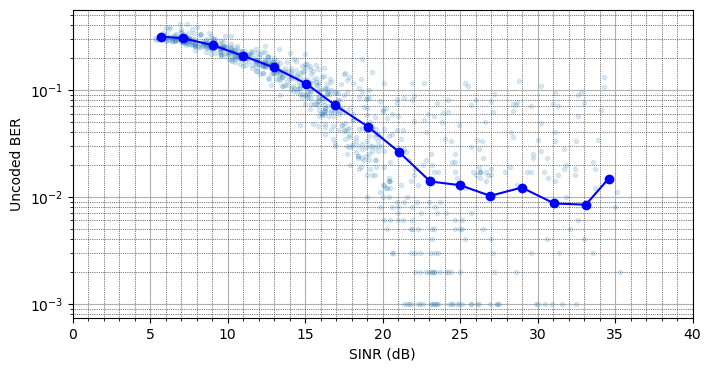

In [6]:
import pandas as pd

df = pd.DataFrame(SINR2BER_table, columns=['txg', 'rxg', 'SINR', 'BER'])
df['SINR_binned'] = pd.cut(df['SINR'], bins=range(-10, 40, 2), labels=range(-9, 39, 2))
df_grouped = df.groupby('SINR_binned', observed=False).mean()

plt.figure(figsize=(8, 4))
plt.plot(df['SINR'], df['BER'], 'o', alpha=0.15, markersize=3)
plt.xlabel('SINR (dB)')
plt.ylabel('Uncoded BER')
plt.plot(df_grouped['SINR'], df_grouped['BER'], '-o', color='blue')
#plt.title(f'OFDM System Uncoded Performance\n Qm={Qm}, FFT_size={FFT_size}, F={F}, S={S}, Fp={Fp}, Sp={Sp}, CP={CP}, SCS={SCS}\nPilot_P={Pilot_Power}, PDSCH_P={PDSCH_power}, freq={SDR_TX_Frequency}Hz')
plt.xlim(0, 40)
plt.yscale('log')
plt.grid()
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
if save_plots:
    plt.savefig('pics/Performance.png')
plt.show()
